In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as  np


## Visión general

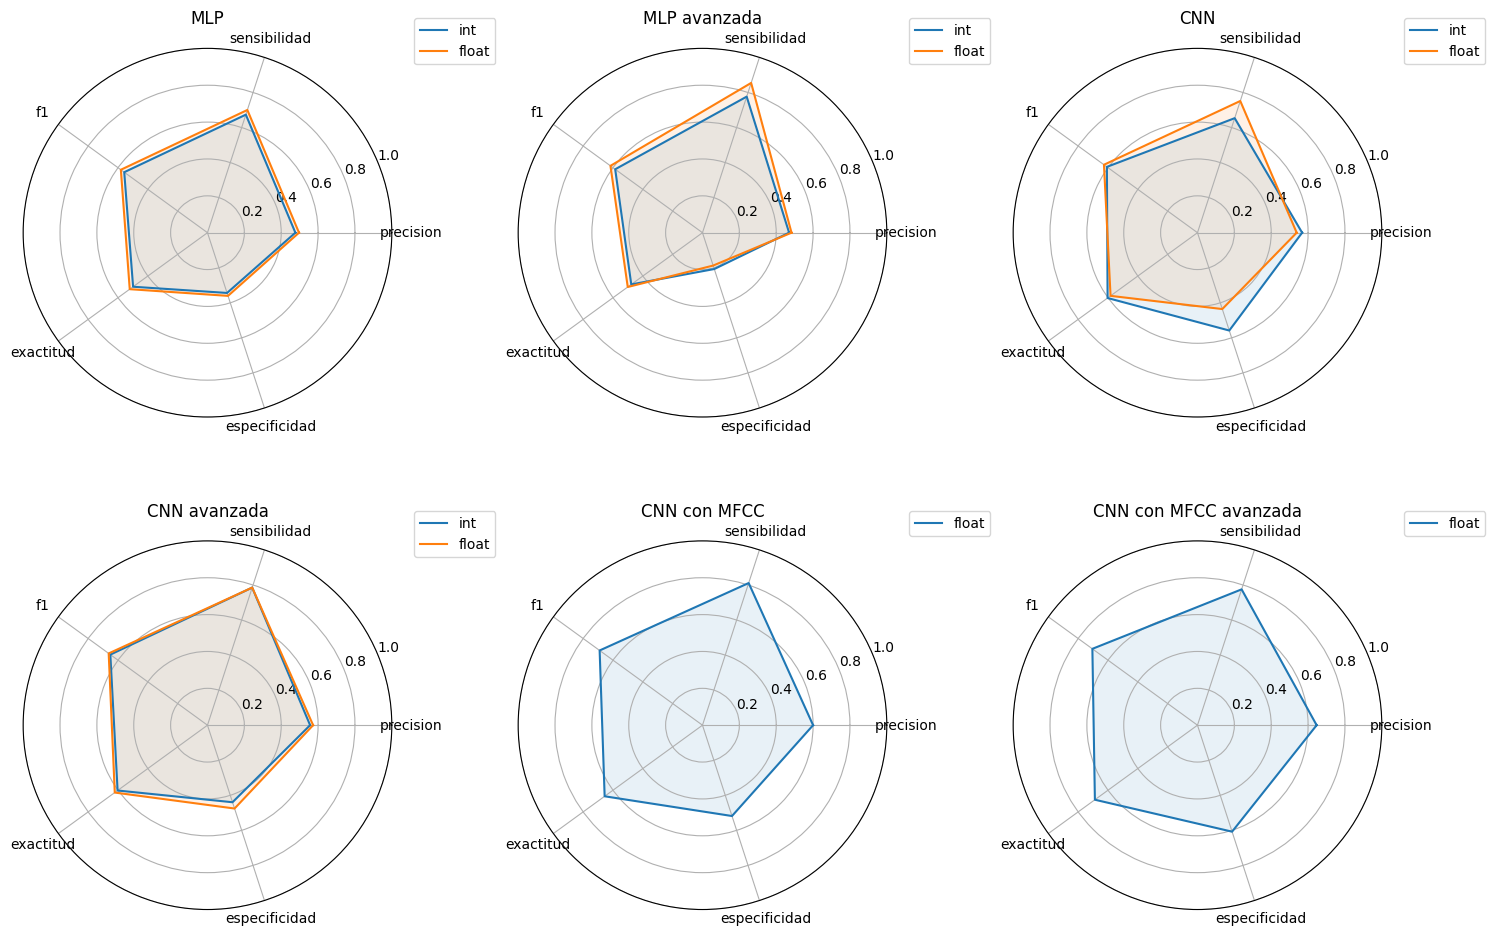

In [ ]:
# Carga de datos (sin modificar el CSV original)
df = pd.read_csv('data/general_metrics.csv')

#  Métricas a visualizar
metrics = ['precision', 'sensibilidad', 'f1', 'exactitud', 'especificidad']

# Extraer “model_base” y “format” de cada model_name
def split_name(name):
    if name.endswith('_int'):
        return name[:-4], 'int'
    elif name.endswith('_float'):
        return name[:-6], 'float'
    else:
        return name, 'float'

df[['model_base', 'format']] = df['model_name'].apply(
    lambda x: pd.Series(split_name(x))
)

# Lista de modelos únicos
model_bases = df['model_base'].unique().tolist()

#  Mapa de títulos

title_map = {
    'model_NN': 'MLP',
    'model_NNA': 'MLP avanzada',
    'model_CNN': 'CNN',
    'model_CNNA': 'CNN avanzada',
    'model_CNN_MFCC': 'CNN con MFCC',
    'model_CNNA_MFCC': 'CNN con MFCC avanzada',
}

# Calcular distribución de subplots
n_models = len(model_bases)
ncols = 3
nrows = int(np.ceil(n_models / ncols))

fig, axes = plt.subplots(
    nrows, ncols,
    figsize=(5 * ncols, 5 * nrows),
    subplot_kw=dict(polar=True)
)
axes = axes.flatten()

# Preparar ángulos del radar
angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
angles += angles[:1]  # cerrar el polígono

#  Dibujar cada radar
for ax, model in zip(axes, model_bases):
    subset = df[df['model_base'] == model]
    pivot = subset.set_index('format')[metrics]

    for fmt in pivot.index:
        vals = pivot.loc[fmt].tolist()
        vals += vals[:1]  # cerrar el polígono
        ax.plot(angles, vals, label=fmt)
        ax.fill(angles, vals, alpha=0.1)

    ax.set_thetagrids(np.degrees(angles[:-1]), metrics)
    ax.set_ylim(0, 1)

    # Título personalizado o por defecto
    titulo = title_map.get(model, model)
    ax.set_title(titulo)

    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

# Eliminar ejes sobrantes
for ax in axes[n_models:]:
    fig.delaxes(ax)

plt.tight_layout()
plt.show()

## Cuantización

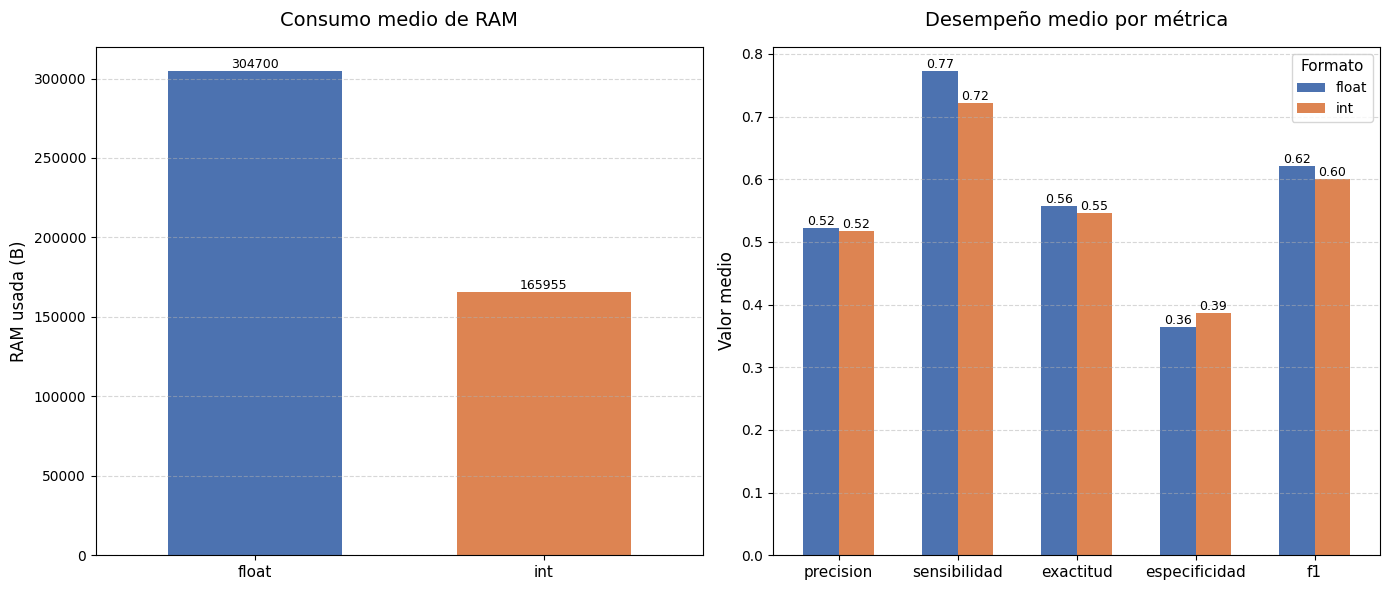

In [ ]:


# Métricas de desempeño
metrics = ['precision', 'sensibilidad', 'exactitud', 'especificidad', 'f1']

# Extraer “model_base” y “format”
def split_name(name):
    if name.endswith('_int'):
        return name[:-4], 'int'
    elif name.endswith('_float'):
        return name[:-6], 'float'
    else:
        return name, 'orig'

df[['model_base', 'format']] = df['model_name'].apply(
    lambda x: pd.Series(split_name(x))
)

# Filtrar para quedarnos solo con MLP y CNN (básica vs avanzada)
models_to_keep = ['model_NN', 'model_NNA', 'model_CNN', 'model_CNNA']
df = df[df['model_base'].isin(models_to_keep)]

# 5. Mapear títulos personalizados
title_map = {
    'model_NN':   'MLP básica',
    'model_NNA':  'MLP avanzada',
    'model_CNN':  'CNN básica',
    'model_CNNA': 'CNN avanzada'
}

# Calcular media de RAM para todas las float vs todas las int
ram_mean = df.groupby('format')['avg_used_ram'].mean().loc[['float','int']]

# Cálculo de desempeño medio por métrica y formato
perf_by_format = (
    df.groupby('format')[metrics]
      .mean()
      .T.loc[:, ['float','int']]
)

# Colores
colors = {'float': '#4C72B0', 'int': '#DD8452'}

# Dibujar subplots 1x2
fig, axes = plt.subplots(1, 2, figsize=(14, 6), tight_layout=True)

# RAM media float vs int
ram_mean.plot(
    kind='bar',
    ax=axes[0],
    color=[colors[f] for f in ram_mean.index],
    width=0.6
)
axes[0].set_title('Consumo medio de RAM', fontsize=14, pad=15)
axes[0].set_ylabel('RAM usada (B)', fontsize=12)
axes[0].grid(axis='y', linestyle='--', alpha=0.5)
axes[0].set_xlabel('')
axes[0].tick_params(axis='x', rotation=0, labelsize=11)
axes[0].legend().remove()

# Anotar valores encima de cada barra
for p in axes[0].patches:
    h = p.get_height()
    axes[0].annotate(f'{h:.0f}',
                     (p.get_x() + p.get_width()/2, h),
                     ha='center', va='bottom', fontsize=9)

# Desempeño medio por métrica
perf_by_format.plot(
    kind='bar',
    ax=axes[1],
    color=[colors[f] for f in perf_by_format.columns],
    width=0.6
)
axes[1].set_title('Desempeño medio por métrica', fontsize=14, pad=15)
axes[1].set_ylabel('Valor medio', fontsize=12)
axes[1].grid(axis='y', linestyle='--', alpha=0.5)
axes[1].set_xlabel('')
axes[1].tick_params(axis='x', rotation=0, labelsize=11)
axes[1].legend(title='Formato', fontsize=10, title_fontsize=11)

# Anotar valores encima de cada barra
for p in axes[1].patches:
    h = p.get_height()
    axes[1].annotate(f'{h:.2f}',
                     (p.get_x() + p.get_width()/2, h),
                     ha='center', va='bottom', fontsize=9)

plt.show()


## Complejidad de la red

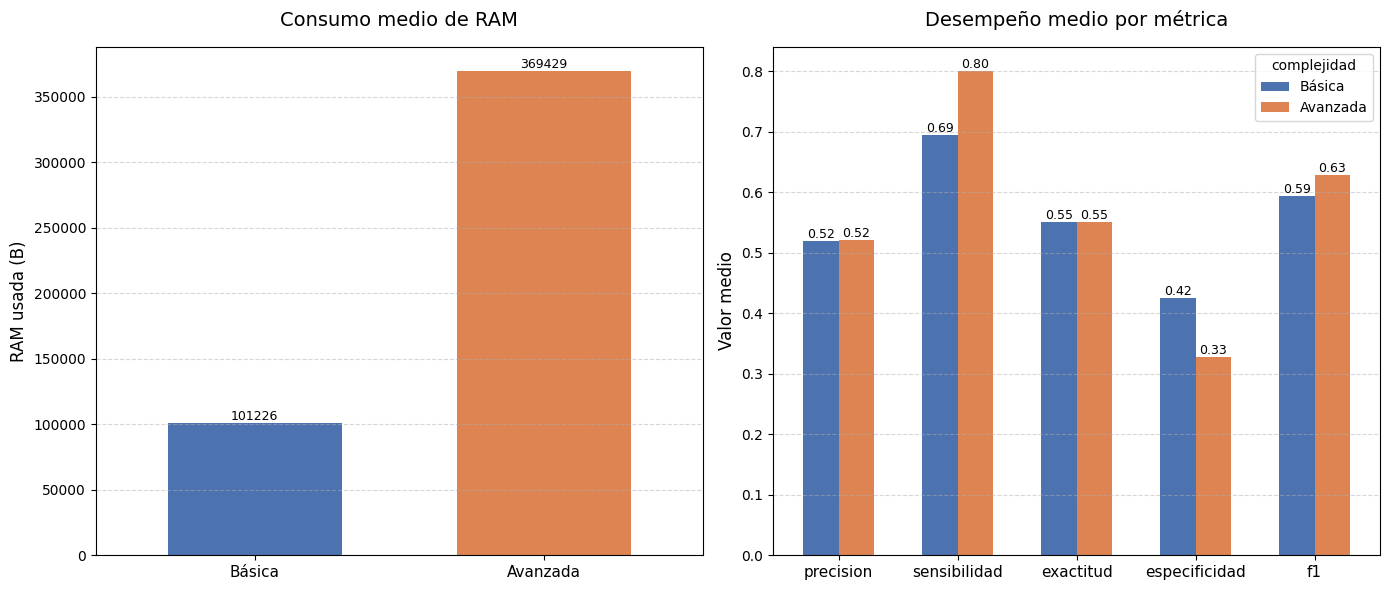

In [4]:
# Métricas de desempeño
metrics = ['precision', 'sensibilidad', 'exactitud', 'especificidad', 'f1']

# Extraer “model_base” y “format”
def split_name(name):
    if name.endswith('_int'):
        return name[:-4], 'int'
    elif name.endswith('_float'):
        return name[:-6], 'float'
    else:
        return name, 'orig'

df[['model_base', 'format']] = df['model_name'].apply(
    lambda x: pd.Series(split_name(x))
)

# Filtrar para quedarnos solo con MLP y CNN (básica vs avanzada)
models_to_keep = ['model_NN', 'model_NNA', 'model_CNN', 'model_CNNA']
df = df[df['model_base'].isin(models_to_keep)]

# Mapear a complejidad: Básica vs Avanzada
complexity_map = {
    'model_NN':   'Básica',
    'model_CNN':  'Básica',
    'model_NNA':  'Avanzada',
    'model_CNNA':'Avanzada'
}
df['complejidad'] = df['model_base'].map(complexity_map)

# Cálculo de RAM medio por complejidad
ram_mean = df.groupby('complejidad')['avg_used_ram'].mean()
# Reordenar para que sea Básica primero, luego Avanzada
ram_mean = ram_mean.reindex(['Básica', 'Avanzada'])

# Cálculo de desempeño medio por métrica y complejidad
perf_mean = df.groupby('complejidad')[metrics].mean().T
# Reordenar las columnas para Básica primero, luego Avanzada
perf_mean = perf_mean[['Básica', 'Avanzada']]

# Colores
colors = {'Básica': '#4C72B0', 'Avanzada': '#DD8452'}

# Dibujar subplots 1x2
fig, axes = plt.subplots(1, 2, figsize=(14, 6), tight_layout=True)

# RAM por complejidad
ram_mean.plot(
    kind='bar',
    ax=axes[0],
    color=[colors[c] for c in ram_mean.index],
    width=0.6
)
axes[0].set_title('Consumo medio de RAM', fontsize=14, pad=15)
axes[0].set_ylabel('RAM usada (B)', fontsize=12)
axes[0].grid(axis='y', linestyle='--', alpha=0.5)
axes[0].set_xlabel('')
axes[0].tick_params(axis='x', rotation=0, labelsize=11)
# Anotar valores
for p in axes[0].patches:
    h = p.get_height()
    axes[0].annotate(f'{h:.0f}',
                     (p.get_x() + p.get_width()/2, h),
                     ha='center', va='bottom', fontsize=9)

# Desempeño medio por métrica ---
perf_mean.plot(
    kind='bar',
    ax=axes[1],
    color=[colors[c] for c in perf_mean.columns],
    width=0.6
)
axes[1].set_title('Desempeño medio por métrica', fontsize=14, pad=15)
axes[1].set_ylabel('Valor medio', fontsize=12)
axes[1].grid(axis='y', linestyle='--', alpha=0.5)
axes[1].set_xlabel('')
axes[1].tick_params(axis='x', rotation=0, labelsize=11)
# Anotar valores
for p in axes[1].patches:
    h = p.get_height()
    axes[1].annotate(f'{h:.2f}',
                     (p.get_x() + p.get_width()/2, h),
                     ha='center', va='bottom', fontsize=9)

plt.show()

## Arquitectura de la red

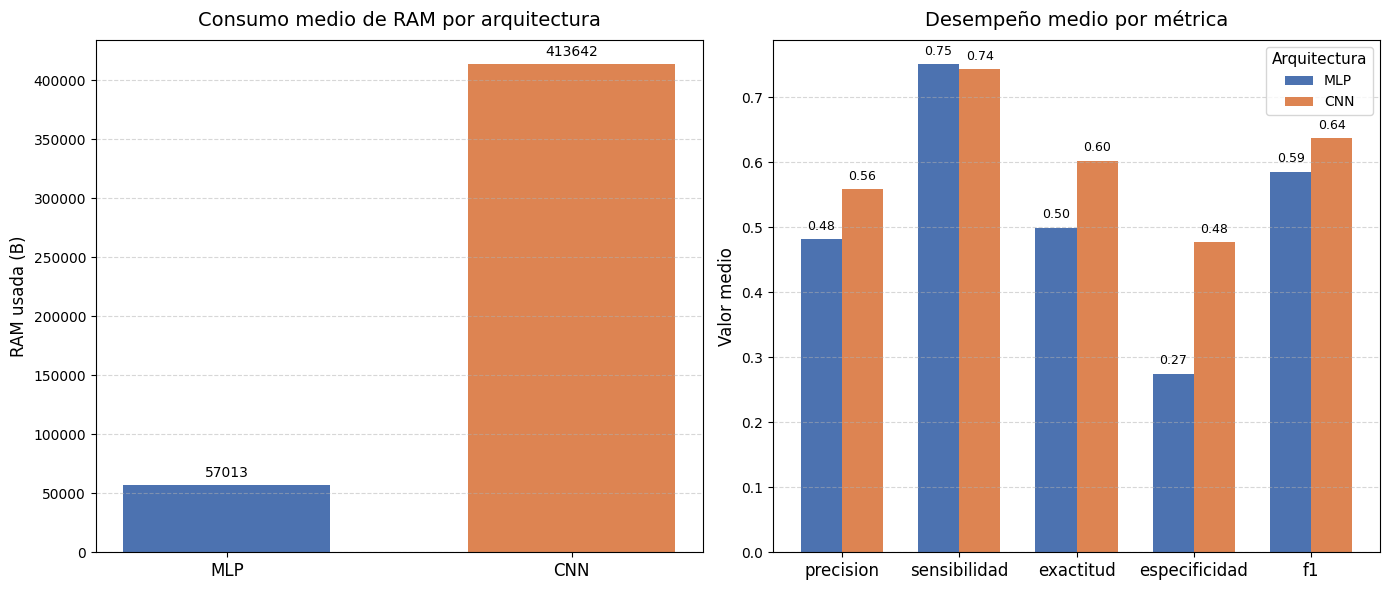

In [ ]:

# Métricas a usar
metrics = ['precision', 'sensibilidad', 'exactitud', 'especificidad', 'f1']

# Extraer “model_base” y “format”
def split_name(name):
    if name.endswith('_int'):
        return name[:-4], 'int'
    elif name.endswith('_float'):
        return name[:-6], 'float'
    else:
        return name, 'orig'

df[['model_base', 'format']] = df['model_name'] \
    .apply(lambda x: pd.Series(split_name(x)))

# Filtrar sólo MLP y CNN (básica vs avanzada), ignorando MFCC
df = df[df['model_base'].isin(['model_NN','model_NNA','model_CNN','model_CNNA'])]

# Mapear a arquitectura: MLP o CNN
arch_map = {
    'model_NN':   'MLP',
    'model_NNA':  'MLP',
    'model_CNN':  'CNN',
    'model_CNNA': 'CNN'
}
df['arch'] = df['model_base'].map(arch_map)

# Calcular consumo medio de RAM por arquitectura
ram_arch = df.groupby('arch')['avg_used_ram'].mean()

# Reordenar para mostrar primero MLP y luego CNN
ram_arch = ram_arch.reindex(['MLP', 'CNN'])

# Calcular desempeño medio por métrica y arquitectura
perf_arch = df.groupby('arch')[metrics].mean().T

# Colores
colors = {'MLP': '#4C72B0', 'CNN': '#DD8452'}

# Dibujar subplots 1x2
fig, (ax_ram, ax_perf) = plt.subplots(1, 2, figsize=(14, 6), tight_layout=True)

# MLP vs CNN
x = np.arange(len(ram_arch))
bars = ax_ram.bar(
    x,
    ram_arch.values,
    color=[colors[a] for a in ram_arch.index],
    width=0.6
)
ax_ram.set_xticks(x)
ax_ram.set_xticklabels(ram_arch.index, fontsize=12)
ax_ram.set_title('Consumo medio de RAM por arquitectura', fontsize=14, pad=10)
ax_ram.set_ylabel('RAM usada (B)', fontsize=12)
ax_ram.grid(axis='y', linestyle='--', alpha=0.5)

for bar in bars:
    h = bar.get_height()
    ax_ram.text(
        bar.get_x() + bar.get_width()/2,
        h + ram_arch.max()*0.01,
        f'{h:.0f}',
        ha='center', va='bottom', fontsize=10
    )

# métricas MLP vs CNN
width = 0.35
x2 = np.arange(len(metrics))

bar1 = ax_perf.bar(
    x2 - width/2,
    perf_arch['MLP'],
    width,
    label='MLP',
    color=colors['MLP']
)
bar2 = ax_perf.bar(
    x2 + width/2,
    perf_arch['CNN'],
    width,
    label='CNN',
    color=colors['CNN']
)

ax_perf.set_xticks(x2)
ax_perf.set_xticklabels(metrics, fontsize=12)
ax_perf.set_title('Desempeño medio por métrica', fontsize=14, pad=10)
ax_perf.set_ylabel('Valor medio', fontsize=12)
ax_perf.legend(title='Arquitectura', fontsize=10, title_fontsize=11)
ax_perf.grid(axis='y', linestyle='--', alpha=0.5)

for bar in (*bar1, *bar2):
    h = bar.get_height()
    ax_perf.text(
        bar.get_x() + bar.get_width()/2,
        h + 0.01,
        f'{h:.2f}',
        ha='center', va='bottom', fontsize=9
    )

plt.show()


## Preprocesamiento

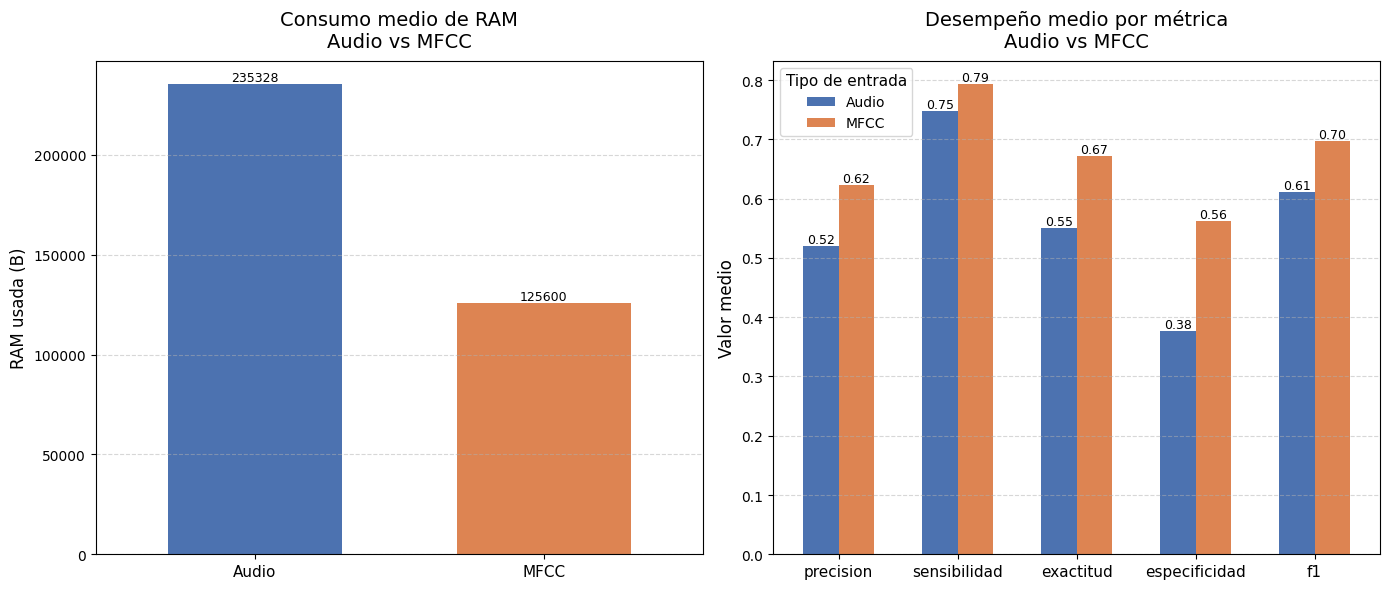

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Carga de datos
df = pd.read_csv('data/general_metrics.csv')

# Métricas a comparar
metrics = ['precision', 'sensibilidad', 'exactitud', 'especificidad', 'f1']

# Extraer “model_base” y “format” de model_name
def split_name(name):
    if name.endswith('_int'):
        return name[:-4], 'int'
    elif name.endswith('_float'):
        return name[:-6], 'float'
    else:
        return name, 'orig'

df[['model_base', 'format']] = df['model_name'].apply(
    lambda x: pd.Series(split_name(x))
)

#Filtrar solo modelos de interés (incluyendo MFCC)
valid = [
    'model_NN', 'model_NNA',
    'model_CNN', 'model_CNNA',
    'model_CNN_MFCC', 'model_CNNA_MFCC'
]
df = df[df['model_base'].isin(valid)]

# Definir tipo de entrada: Audio vs MFCC
df['input_type'] = df['model_base'].apply(
    lambda mb: 'MFCC' if mb.endswith('_MFCC') else 'Audio'
)

# Calcular consumo medio de RAM por input_type
ram_mean = df.groupby('input_type')['avg_used_ram'].mean()
ram_mean = ram_mean.reindex(['Audio', 'MFCC'])  # asegura ambos grupos

# Calcular desempeño medio por métrica y input_type
perf_by_type = df.groupby('input_type')[metrics].mean().T
perf_by_type = perf_by_type[['Audio', 'MFCC']]

# Colores
colors = {'Audio': '#4C72B0', 'MFCC': '#DD8452'}

# Dibujar subplots 1x2
fig, (ax_ram, ax_perf) = plt.subplots(1, 2, figsize=(14, 6), tight_layout=True)

# RAM Audio vs MFCC
ram_mean.plot(
    kind='bar',
    ax=ax_ram,
    color=[colors[t] for t in ram_mean.index],
    width=0.6
)
ax_ram.set_title('Consumo medio de RAM\nAudio vs MFCC', fontsize=14, pad=10)
ax_ram.set_ylabel('RAM usada (B)', fontsize=12)
ax_ram.grid(axis='y', linestyle='--', alpha=0.5)
ax_ram.set_xlabel('')
ax_ram.tick_params(axis='x', rotation=0, labelsize=11)
# Anotar valores
for p in ax_ram.patches:
    h = p.get_height()
    ax_ram.annotate(f'{h:.0f}',
                     (p.get_x() + p.get_width()/2, h),
                     ha='center', va='bottom', fontsize=9)

# métrica Audio vs MFCC ---
perf_by_type.plot(
    kind='bar',
    ax=ax_perf,
    color=[colors[t] for t in perf_by_type.columns],
    width=0.6
)
ax_perf.set_title('Desempeño medio por métrica\nAudio vs MFCC', fontsize=14, pad=10)
ax_perf.set_ylabel('Valor medio', fontsize=12)
ax_perf.grid(axis='y', linestyle='--', alpha=0.5)
ax_perf.set_xlabel('')
ax_perf.tick_params(axis='x', rotation=0, labelsize=11)
ax_perf.legend(title='Tipo de entrada', fontsize=10, title_fontsize=11)
# Anotar valores
for p in ax_perf.patches:
    h = p.get_height()
    ax_perf.annotate(f'{h:.2f}',
                     (p.get_x() + p.get_width()/2, h),
                     ha='center', va='bottom', fontsize=9)

plt.show()


## Gráficas adicionales

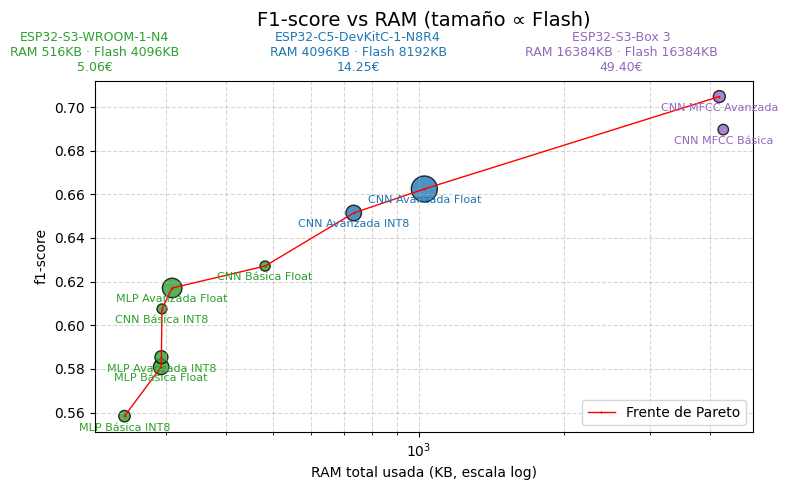

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Carga de datos
df = pd.read_csv('data/general_metrics.csv')

# Mapas de Flash y etiquetas
flash_map = {
    'model_NN_int':      503.17188,
    'model_NN_float':    1.95741 * 1024,
    'model_NNA_int':     1007.81250,
    'model_NNA_float':   3.92104 * 1024,
    'model_CNN_int':     28.25000,
    'model_CNN_float':   88.11719,
    'model_CNNA_int':    1.98810 * 1024,
    'model_CNNA_float':  7.91093 * 1024,
    'model_CNN_MFCC':    204.07031,
    'model_CNNA_MFCC':   656.87500
}
df['flash_kb'] = df['model_name'].map(flash_map)
label_map = {
    'model_NN_int':'MLP Básica INT8','model_NN_float':'MLP Básica Float',
    'model_NNA_int':'MLP Avanzada INT8','model_NNA_float':'MLP Avanzada Float',
    'model_CNN_int':'CNN Básica INT8','model_CNN_float':'CNN Básica Float',
    'model_CNNA_int':'CNN Avanzada INT8','model_CNNA_float':'CNN Avanzada Float',
    'model_CNN_MFCC':'CNN MFCC Básica','model_CNNA_MFCC':'CNN MFCC Avanzada'
}
df['label'] = df['model_name'].map(label_map)

# Extras de RAM dependiendo de MFCC o audio
extra = {
    'amplitude': {'ext': 230*1024},
    'mfcc':      {'ext': 4*1024*1024}
}
df['extra_ext_B'] = df['model_name'].apply(
    lambda n: extra['mfcc']['ext'] if 'MFCC' in n.upper() else extra['amplitude']['ext']
)

# Calcular RAM total usada (bytes -> KB)
df['ram_kb'] = (df['avg_used_ram'] + df['extra_ext_B']) / 1024

# Asignar dispositivo
devices = [
    ('ESP32-S3-WROOM-1-N4',    516,      4*1024,   5.06),
    ('ESP32-C5-DevKitC-1-N8R4',4*1024,   8*1024,   14.25),
    ('ESP32-S3-Box 3',        16*1024,  16*1024,   49.40),
]
def assign_device(r, f):
    for name, ram_lim, flash_lim, price in devices:
        if r <= ram_lim and f <= flash_lim:
            return name
    return 'None'
df['device'] = df.apply(lambda row: assign_device(row['ram_kb'], row['flash_kb']), axis=1)

# Colores
colors = {
    'ESP32-S3-WROOM-1-N4':    'tab:green',
    'ESP32-C5-DevKitC-1-N8R4':'tab:blue',
    'ESP32-S3-Box 3':         'tab:purple',
    'None':                   'tab:gray'
}

# Cálculo del frente de Pareto
df_sorted = df.sort_values('ram_kb')
pareto_idx = []
max_f1 = -np.inf
for idx, row in df_sorted.iterrows():
    if row['f1'] > max_f1:
        pareto_idx.append(idx)
        max_f1 = row['f1']
pareto_df = df.loc[pareto_idx].sort_values('ram_kb')

# Gráfico principal
plt.figure(figsize=(8,5))
flash_sizes = (df['flash_kb'] / df['flash_kb'].max()) * 300 + 50
y_span = df['f1'].max() - df['f1'].min()
offset = 0.02 * y_span

# Puntos por dispositivo
for dev, grp in df.groupby('device'):
    plt.scatter(
        grp['ram_kb'], grp['f1'],
        s=flash_sizes[grp.index],
        color=colors.get(dev, 'gray'),
        alpha=0.8, edgecolor='k'
    )
# Etiquetas
for _, row in df.iterrows():
    plt.text(
        row['ram_kb'], row['f1'] - offset,
        row['label'], fontsize=8,
        ha='center', va='top',
        color=colors.get(row['device'], 'gray')
    )

# Dibujar el frente de Pareto
plt.plot(
    pareto_df['ram_kb'], pareto_df['f1'],
    color='red', marker='.', linestyle='-',
    linewidth=1, markersize=1,
    label='Frente de Pareto'
)

# Encabezados de placas
plt.title('F1-score vs RAM (tamaño ∝ Flash)', pad=40, fontsize=14)
for i, (name, rlim, flim, price) in enumerate(devices):
    x_frac = i / (len(devices)-0.5)
    plt.text(
        x_frac, 1.02,
        f"{name}\nRAM {rlim}KB · Flash {flim}KB\n{price:.2f}€",
        transform=plt.gca().transAxes,
        ha='center', va='bottom',
        fontsize=9, color=colors[name]
    )
plt.xscale('log')
plt.xlabel('RAM total usada (KB, escala log)')
plt.ylabel('f1-score')
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


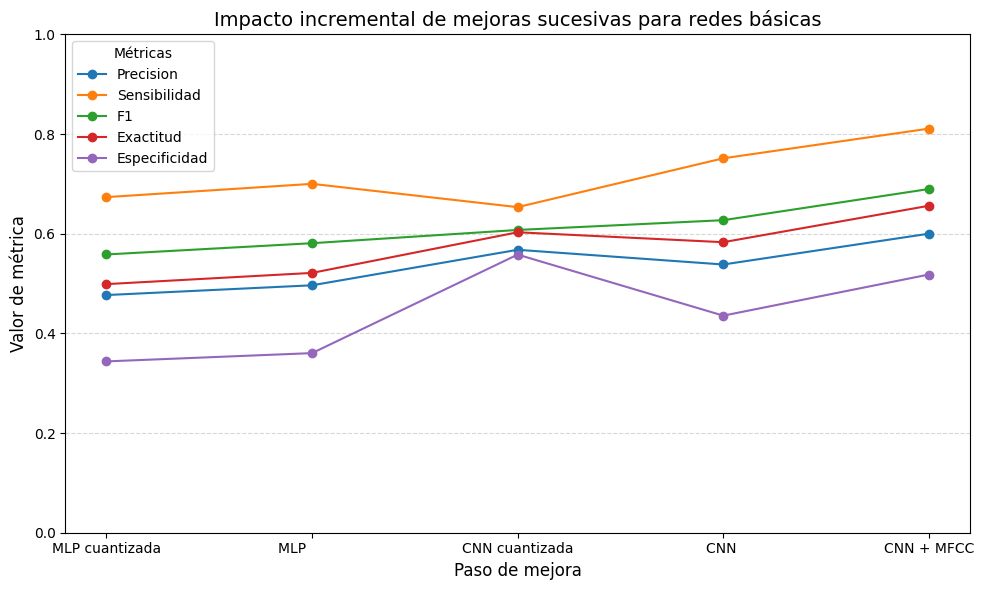

In [ ]:
# Carga de datos
df = pd.read_csv('data/general_metrics.csv')

# Definición de pasos sucesivos y sus etiquetas
steps = [
    ("MLP cuantizada",       "model_NN_int"),
    ("MLP         ",         "model_NN_float"),
    ("CNN cuantizada",       "model_CNN_int"),
    ("CNN ",                 "model_CNN_float"),
    ("CNN + MFCC",           "model_CNN_MFCC"),
]

# Métricas a evaluar
metrics = ["precision", "sensibilidad", "f1", "exactitud", "especificidad"]

# Extraer valores para cada paso
data = []
for label, model_name in steps:
    row = df[df["model_name"] == model_name].iloc[0]
    data.append([row[m] for m in metrics])

# Construir DataFrame
impact_df = pd.DataFrame(data, index=[s[0] for s in steps], columns=metrics)

# Gráfico de líneas
plt.figure(figsize=(10, 6))
for metric in metrics:
    plt.plot(
        impact_df.index,
        impact_df[metric],
        marker='o',
        label=metric.capitalize()
    )

plt.title("Impacto incremental de mejoras sucesivas para redes básicas", fontsize=14)
plt.xlabel("Paso de mejora", fontsize=12)
plt.ylabel("Valor de métrica", fontsize=12)
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend(title="Métricas")
plt.tight_layout()
plt.show()
